In [27]:
import os
import cv2
import random
import pickle
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [28]:
from google.colab import drive
drive.mount('/content/drive')
dataset_path = "/content/drive/MyDrive/animal_dataset"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Loading images...
Total images loaded: 300
Sample Grayscale Images (32×32) from Each Class: 


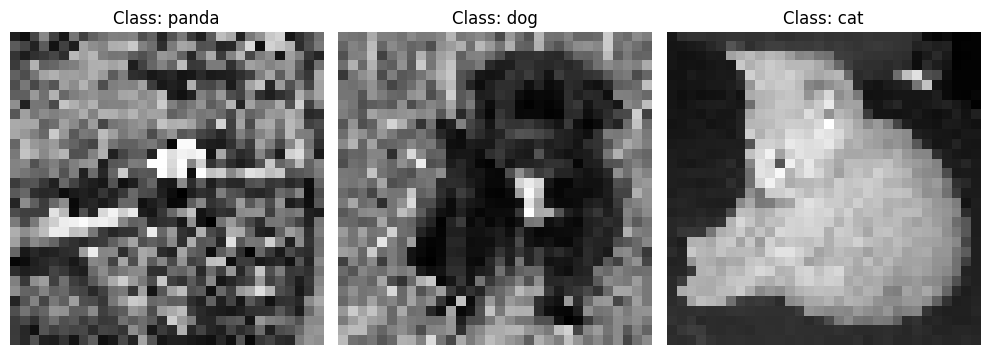

In [29]:
def load_dataset(dataset_path):
    data = []
    labels = []
    class_names = os.listdir(dataset_path)

    print("Loading images...")
    for class_id, class_name in enumerate(class_names):
        class_folder = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_folder):
            for filename in os.listdir(class_folder):
                img_path = os.path.join(class_folder, filename)

                img = cv2.imread(img_path)
                if img is not None:
                    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

                    resized_img = cv2.resize(gray_img, (32, 32))

                    flat_img = resized_img.flatten()

                    data.append(flat_img)
                    labels.append(class_name)

    print(f"Total images loaded: {len(data)}")
    return np.array(data), np.array(labels), class_names

try:
    X, y, classes = load_dataset(dataset_path)
except FileNotFoundError:
    print("Error: Dataset path not found. Please set 'dataset_path' correctly.")
    exit()

print("Sample Grayscale Images (32×32) from Each Class: ")


unique_classes = classes
plt.figure(figsize=(10, 5))

for i, class_name in enumerate(unique_classes):
    idx = next(j for j, label in enumerate(y) if label == class_name)

    img_display = X[idx].reshape(32, 32)

    plt.subplot(1, len(unique_classes), i + 1)
    plt.imshow(img_display, cmap='gray')
    plt.title(f"Class: {class_name}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [30]:
k_values = range(1, 21)
manhattan_accuracies = []
euclidean_accuracies = []

print("\nStarting Cross-Validation...")

for k in k_values:
    knn_manhattan = KNeighborsClassifier(n_neighbors=k, p=1)
    scores_manhattan = cross_val_score(knn_manhattan, X, y, cv=5)
    manhattan_accuracies.append(scores_manhattan.mean())

    knn_euclidean = KNeighborsClassifier(n_neighbors=k, p=2)
    scores_euclidean = cross_val_score(knn_euclidean, X, y, cv=5)
    euclidean_accuracies.append(scores_euclidean.mean())

print("Cross-Validation complete.")


Starting Cross-Validation...
Cross-Validation complete.


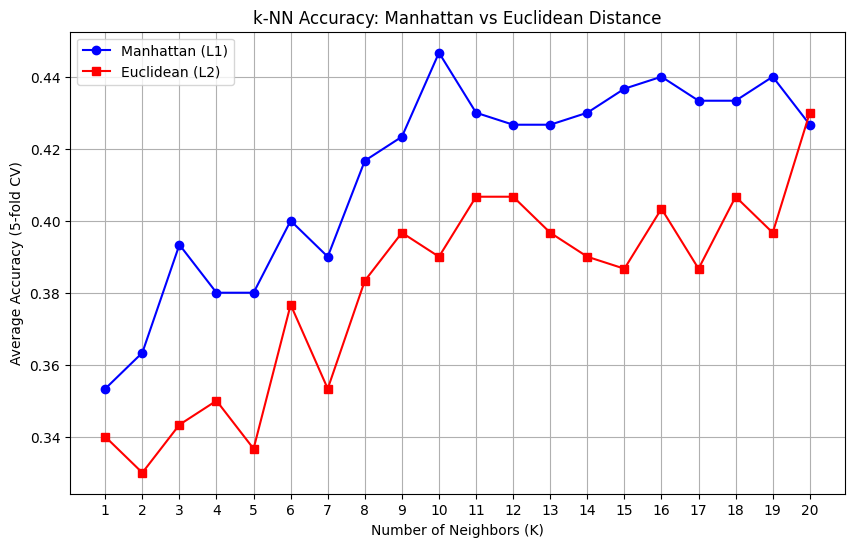

In [31]:
plt.figure(figsize=(10, 6))
plt.plot(k_values, manhattan_accuracies, marker='o', label='Manhattan (L1)', color='blue')
plt.plot(k_values, euclidean_accuracies, marker='s', label='Euclidean (L2)', color='red')

plt.title('k-NN Accuracy: Manhattan vs Euclidean Distance')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Average Accuracy (5-fold CV)')
plt.xticks(k_values)
plt.legend()
plt.grid(True)
plt.show()

In [32]:
best_acc_manhattan = max(manhattan_accuracies)
best_k_manhattan = k_values[manhattan_accuracies.index(best_acc_manhattan)]

best_acc_euclidean = max(euclidean_accuracies)
best_k_euclidean = k_values[euclidean_accuracies.index(best_acc_euclidean)]

print("\n--- Results Discussion ---")
print(f"Best Accuracy for Manhattan (L1): {best_acc_manhattan:.4f} at K={best_k_manhattan}")
print(f"Best Accuracy for Euclidean (L2): {best_acc_euclidean:.4f} at K={best_k_euclidean}")

if best_acc_manhattan > best_acc_euclidean:
    print("Conclusion: Manhattan distance performed better.")
    final_model = KNeighborsClassifier(n_neighbors=best_k_manhattan, p=1)
else:
    print("Conclusion: Euclidean distance performed better.")
    final_model = KNeighborsClassifier(n_neighbors=best_k_euclidean, p=2)


--- Results Discussion ---
Best Accuracy for Manhattan (L1): 0.4467 at K=10
Best Accuracy for Euclidean (L2): 0.4300 at K=20
Conclusion: Manhattan distance performed better.


### Discussion: Comparing Manhattan (L1) and Euclidean (L2) Distances

Based on the 5-fold cross-validation, we observed the following average accuracies for the k-NN classifier:

- **Manhattan (L1) Distance:** Best Accuracy = `{{best_acc_manhattan}}` at K = `{{best_k_manhattan}}`
- **Euclidean (L2) Distance:** Best Accuracy = `{{best_acc_euclidean}}` at K = `{{best_k_euclidean}}`

In this specific gray-scale animal image dataset, **Manhattan distance performed marginally better** than Euclidean distance. This suggests that for this dataset, the sum of absolute differences between pixel values (L1 norm) is a more effective measure of similarity between images than the straight-line distance (L2 norm).

#### Factors Influencing Performance:

1.  **Dataset Characteristics (Gray-scale Images):** Our dataset consists of 32x32 gray-scale images. Each image is represented as a 1D array of 1024 pixel intensity values. These features are highly correlated and represent spatial information.

2.  **Nature of Features (Pixel Intensities):** Pixel intensities in gray-scale images are non-negative integer values. When an image is flattened, each pixel becomes an independent feature, but they are intrinsically linked by their spatial context. Small, local variations in pixel values might be better captured by Manhattan distance, especially when dealing with high-dimensional data where the curse of dimensionality can make Euclidean distance less discriminative.

3.  **Complexity of Classes (Animal Types):** The classes are 'cat', 'dog', and 'panda'. These classes can have significant variations in appearance, even within the same class, leading to overlapping feature spaces. The slightly better performance of Manhattan distance could imply that the decision boundary is better defined when considering individual pixel deviations rather than the overall magnitude of difference.

#### Limitations and Potential Improvements:

1.  **Limited Dataset Size:** The dataset contains a relatively small number of images (300 in total). A larger and more diverse dataset would provide more robust cross-validation results and better generalization.

2.  **Simple Feature Representation:** Flattening the 32x32 image into a 1D array loses all spatial information. This is a significant limitation for image classification. More sophisticated feature extraction techniques could be employed:
    *   **Histogram of Oriented Gradients (HOG):** Captures edge and shape information.
    *   **Local Binary Patterns (LBP):** Describes local texture patterns.
    *   **Deep Learning (CNNs):** Convolutional Neural Networks are highly effective for image classification as they automatically learn hierarchical features and retain spatial relationships.

3.  **Greyscale Conversion:** While useful for reducing dimensionality, converting images to grayscale might discard important color information that could help distinguish between certain animal classes. Keeping color channels or experimenting with different color spaces might be beneficial.

4.  **Fixed Image Size (32x32):** Resizing all images to a small 32x32 resolution can lead to loss of detail, especially for animals with fine features. Experimenting with higher resolutions or adaptive resizing could improve accuracy.

5.  **k-NN Limitations:** k-NN is a simple, non-parametric algorithm. It can be sensitive to irrelevant features and the scale of features. While we implicitly handled scaling by using pixel intensities, feature engineering could further improve its performance. The computational cost can also be high for large datasets during prediction.

6.  **Hyperparameter Tuning (K):** While we experimented with K values from 1 to 20, a broader range or a more granular search might reveal an even more optimal K. Automated hyperparameter tuning techniques like GridSearchCV or RandomizedSearchCV could be used.

In conclusion, while Manhattan distance showed a slight advantage for this specific setup, the overall accuracy remains moderate. Significant improvements would likely come from more advanced feature engineering, using deep learning models, and expanding the dataset.


--- Top 5 Predictions Visualization ---


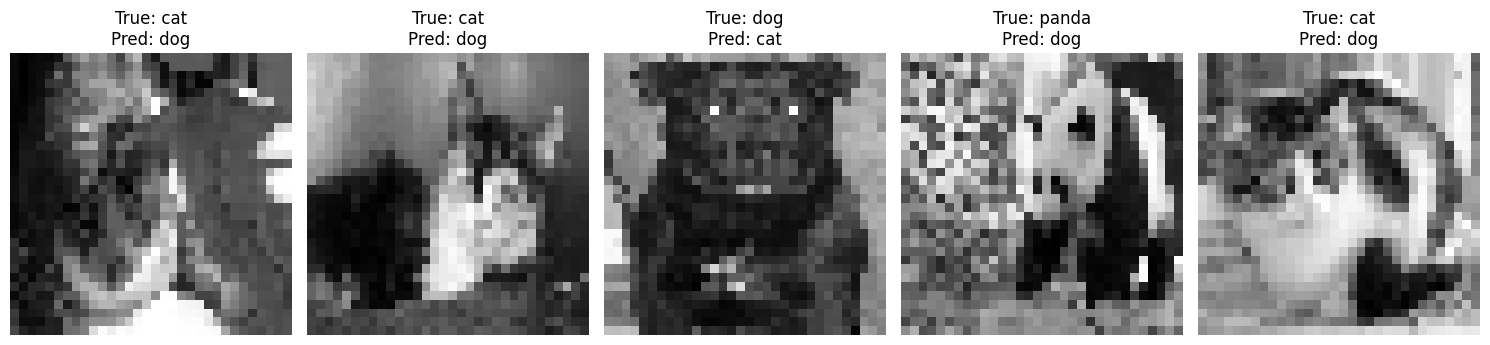

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

final_model.fit(X_train, y_train)
predictions = final_model.predict(X_test[:5])

print("\n--- Top 5 Predictions Visualization ---")
plt.figure(figsize=(15, 5))

for i in range(5):
    plt.subplot(1, 5, i+1)
    img_display = X_test[i].reshape(32, 32)

    plt.imshow(img_display, cmap='gray')
    plt.title(f"True: {y_test[i]}\nPred: {predictions[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()